# Overview

Simulation of M2 measurement of a laser beam subject to spherical aberrations as discussed in Wirthl2021.

The simulation is done using explicit integration of Fresnel's approximation to Kirchhoff's diffraction formula (rotational symmetric only), physical optics propagation (POP) by using FFT to solve Fresnel's approximation (2D), and by decomposing the beam into Laguerre-Gaussian modes (2D).

The `poppy` package and its `FresnelWavefront` class, which implements Fresnel diffraction using 2D FFT, is used for POP. Note however that `poppy` is not written for this kind of calculation, but rather for simulation optical instruments and is thus optimized for operations like moving into the Fourier plane. Here, thus only one subroutine using an FFT implementation of Fresnel diffraction (Fresnel's approximation to the Kirchhoff diffraction equation) is used, `wf._propagate_ptp`.
Using other routines *will* lead to erroneous results, as `poppy` tries to do some internal optimization/magic, such as assuming a transformation into the Fourier plane when scanning around the focus in an M2 measurement. This does not only affect the propagation methods such as `wf.propagate_fresnel`, but also e.g. `poppy.QuadraticLens`, which adds a quadratic phase corresponding to a paraxial ideal lens. `poppy` does not always add the expected lens phase (`k/(2 f) r^2`), but adapts it to the Gaussian beam parameters. This will lead to errors.

Even so, the results with POP are quite different from those of the explicit integration and the mode decomposition. The latter two are in very good agreement however and reproduce the experimental results much more faithfully.

Written by Lothar Maisenbacher for the 2S-nP hydrogen spectroscopy project at MPQ.

Part of my collection of diffraction scripts in `https://gitlab.mpcdf.mpg.de/lmaisen/diffractioncalc`.

# References
Siegman1986:
Siegman, Anthony E. Lasers. University Science Books, 1986.

Wirthl2021:
Wirthl, Vitaly, Lothar Maisenbacher, Johannes Weitenberg, Alexander Hertlein, Alexey Grinin, Arthur Matveev, et al. “Improved Active Fiber-Based Retroreflector with Intensity Stabilization and a Polarization Monitor for the near UV.” Optics Express 29, no. 5 (March 1, 2021): 7024–48. https://doi.org/10.1364/OE.417455.

MaisenbacherThesis:
Maisenbacher, Lothar. “Precision Spectroscopy of the 2S-nP Transitions in Atomic Hydrogen.” PhD, Ludwig-Maximilians-Universität München, 2020.

In [4]:
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.io.fits as fits
import scipy.optimize
import scipy.special
import scipy.integrate
import logging

import gaussian_beam

In [5]:
logging.basicConfig()
logger = logging.getLogger()
# Switch on debug output of poppy (containing information on which algorithms are used)
# logger.setLevel(logging.DEBUG)
# Switch off debug output of poppy (containing information on which algorithms are used)
logger.setLevel(logging.INFO)

In [6]:
def fresnel_integral_kernel(r, rd, z, wavelength):
    """
    Integral kernel of the Fresnel approximation to Kirchhoff's diffraction formula
    (see Siegman1986, Ch. 16, Eq. (18)).
    In cylindrical coordinates for rotationally symmetry input field.
    Gives the electric field at point (`r`, `z`), with `r` radial position and `z` object
    distance, originating from point (`rd`, `0`), for wavelength `wavelength`.
    """
    k0 = 2*np.pi/wavelength
    return (
        1j*2*np.pi/(z*wavelength)
        * np.exp(-1j*k0*z)
        * np.exp(-1j*k0*r**2/2/z)
        * rd
        * np.exp(-1j*k0*rd**2/2/z)
        * scipy.special.jv(0, k0*r*rd/z)
        )

def calc_fresnel_disc_e(rd, Ed, r, z, wavelength):
    """
    Discrete, explicit evaluation of Fresnel diffraction for an electric field `Ed` given at
    discrete sampled points `rd`, e.g., from ZEMAX POP, to a plane at distance `z` and sampled at
    points `r`. The wavelength is given by `wavelength`.
    Note however that a large number of points is needed to give satisfactory results, which might
    not be available. In this case, one can interpolate the electric field first,
    granted that it is sufficiently smooth, and then integrate this function.
    """
    DiffIntReal = lambda r: np.real(fresnel_integral_kernel(r, rd, z, wavelength)*Ed)
    DiffIntImag = lambda r: np.imag(fresnel_integral_kernel(r, rd, z, wavelength)*Ed)

    diff_er = np.zeros(len(r), dtype=np.complex128)
    for i, ra in enumerate(r):
        a = scipy.integrate.trapz(DiffIntReal(ra),rd)
        b = scipy.integrate.trapz(DiffIntImag(ra),rd)
        diff_er[i] = a+1j*b

    return diff_er  

def add_wavefront_curvature(wf, roc):
    """Add wavefront curvature with radius of curvature of `roc` to poppy field `wf`."""
    Y, X = wf.coordinates()
    k = 2*np.pi/wf.wavelength.to('m').value
    wf.wavefront *= np.exp(1j*k/(2*roc.to('m').value)*(X**2+Y**2))
    return wf

def add_lens_phase(wf, f):
    """
    Add wavefront curvature corresponding to the action of a lens with focal length `f` to
    poppy field `wf`.
    Cf. Eq. (4) of Wirthl2021, which however has a sign incompatible (-) with the convention used in
    the rest of the paper. We here instead use a positive phase for a converging lens, which
    corresponds to the spatial propagation phase of a wave to `-kz`.
    """
    Y, X = wf.coordinates()
    k = 2*np.pi/wf.wavelength.to('m').value
    wf.wavefront *= np.exp(1j*k/(2*f.to('m').value)*(X**2+Y**2))
    return wf

def add_spherical_aberration_phase(wf, s, w):
    """
    Add wavefront curvature corresponding to spherical aberration with strength `s`
    to the poppy field `wf` with the beam radius `w`.
    The focusing effect of the spherical aberration is removed by the quadratic term.
    Cf. Eq. (4) of Wirthl2021. Sign corresponds to spatial propagation phase of `-kz`.
    """
    Y, X = wf.coordinates()
    wf.wavefront *= np.exp(
        1j*s*(
            ((X**4+Y**4)/w.to('m').value**4)
            -(2*(X**2+Y**2)/w.to('m').value**2)))    
    return wf

def abcd_thin_lens(f):
    """ABCD matrix for thin lens with focal length `f`."""
    invf = np.inf if f == 0 else 1/f
    return np.array(((1, 0), (-invf, 1)))

gaussian_profile_1d = lambda x, w: np.exp(-x**2/w**2)
gaussian_profile_int_1d = lambda x, w: np.exp(-2*x**2/w**2)

88.57758798901952 m
0.0034 m


Text(0.5, 0.98, 'Entrance Pupil')

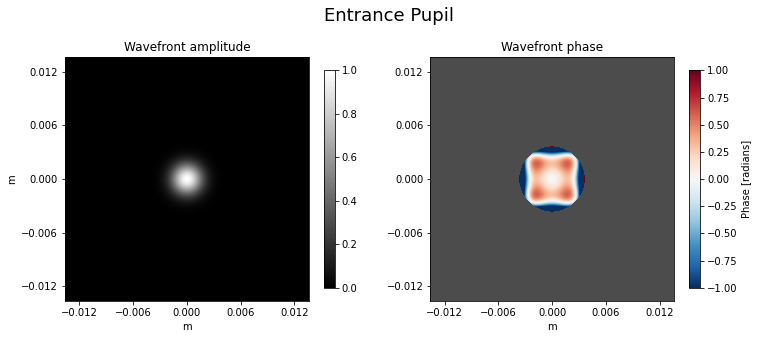

In [7]:
# Oversampling, i.e., factor by which sample size will be increased
# to suppress FFT artifacts
num_oversample = 4
# Number of iterations of Fox-Li method
num_iter = 20

aperture_func = None
initial_wavefront_roc = None
initial_s = None

# Three-lens collimator for hydrogen 2S-6P spectroscopy discussed in Wirthl2021
# Wavelength
wavelength = 410*u.nm
# Number of pixels in sample
num_pixels = 1024
# Aperture function
aperture_func = None
# Start beam profile
initial_gaussian_radius = 1.7*u.mm
# Physical sample size (full width)
sample_size = 4*initial_gaussian_radius
# Initial wavefront curvature radius
initial_wavefront_roc = None
# Add spherical aberration with strength `s`
# Note that the sign of the strength here is opposite to that of Wirthl2021,
# but the convention of Eq. (4) of Wirthl2021 are kept. This is because of a sign difference
# in the Fresnel integral kernel used here and in Wirthl2021. The sign choice here makes sure that
# a beam that goes through a convex lens, i.e., that adds more phase in the center of the lens,
# is focused as it propagates along the positive z-direction.
initial_s = -0.3

num_oversamples = num_pixels*num_oversample
ind_c = num_oversamples//2
oversample_size = sample_size*num_oversample
x = np.arange(num_oversamples)/(num_oversamples)*oversample_size-oversample_size/2
hroundtrips = np.arange(num_iter+1)

# Empty arrays
wavefront_cuts = np.zeros((num_iter+1, num_oversamples), dtype=np.complex128)
wavefronts = np.zeros((num_iter+1, num_oversamples, num_oversamples), dtype=np.complex128)

# Initial field
wf = poppy.FresnelWavefront(
    sample_size/2, wavelength=wavelength,
    npix=num_pixels, oversample=num_oversample)

# Set-up Gaussian beam with given radius and wavefront curvature
beam = gaussian_beam.GaussianBeam(
    q=0, wavelength=wavelength.to('m').value, w0=initial_gaussian_radius.to('m').value)
Y, X = wf.coordinates()
wf.wavefront = beam.laguerre_gauss(0, 0, np.sqrt(X**2+Y**2), np.arctan2(Y, X))
wf.wavefront /= np.abs(wf.wavefront.max())
wf.wavefront = wf.wavefront.astype(np.complex128)
# if initial_wavefront_roc is not None:
#     wf = add_wavefront_curvature(wf, initial_wavefront_roc)

if aperture_func is not None:
    wf *= aperture_func

# Add spherical aberration with strength `s_param`
if initial_s is not None:
    wf = add_spherical_aberration_phase(wf, initial_s, initial_gaussian_radius)

print(wf.z_r.to('m'))
print(wf.w_0.to('m'))

wavefront_cuts[0] = wf.wavefront[ind_c, :]
wf_initial = wf.copy()
wavefronts[0] = wf.wavefront

plt.figure(figsize=(12, 5))
wf.display('both', colorbar=True, showpadding=True)
plt.suptitle("Entrance Pupil", fontsize=18)

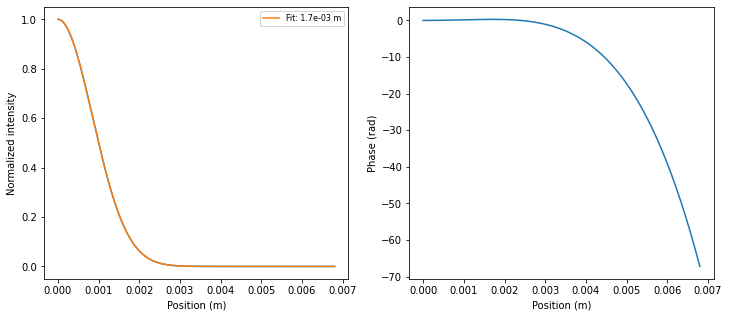

In [8]:
# Plot initial intensity and phase
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = axs[0]
_, X = wf.coordinates()
mask = (x >= 0) & (x <= 1.*sample_size)
# Field amplitude
# y = np.abs(wf.wavefront[ind_c, mask])
# Intensity
y = np.abs(wf.wavefront[ind_c, mask])**2
# Fit 1D Gaussian
pstart = [np.sqrt(np.sum(x[mask]**2*y)/np.sum(y)).to('m').value]
popt, pcov = scipy.optimize.curve_fit(
    gaussian_profile_int_1d, x[mask].to('m').value, y/y.max(), pstart)        
axs[0].plot(
    x[mask].to('m').value,
    y/y.max(),
    )
axs[0].plot(
    x[mask].to('m').value, gaussian_profile_int_1d(x[mask].to('m').value, *popt),
    label=f'Fit: {popt[0]:.1e} m')

# Unwrapped phase of electric field (relative to value at origin)
y = (np.unwrap(np.angle(wf.wavefront[ind_c, mask])))
axs[1].plot(
    x[mask].to('m').value, y-y[0])

for ax in axs:
    ax.set_xlabel(r'Position (m)')
# axs[0].set_ylabel('Normalized amplitude')
axs[0].set_ylabel('Normalized intensity')
axs[1].set_ylabel('Phase (rad)')
axs[0].legend(loc='best', fontsize=8)

5.11e-06


Text(0, 0.5, 'Phase (rad)')

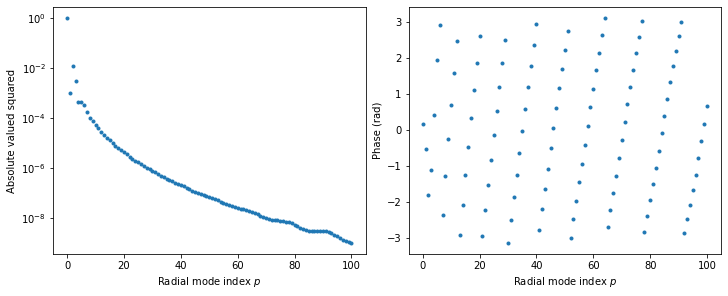

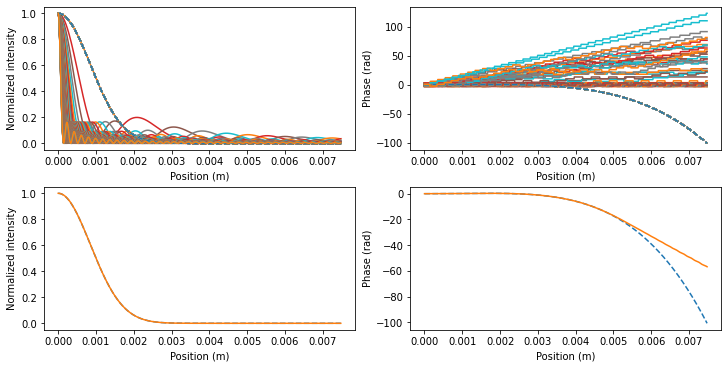

In [9]:
# Find decomposition of calculated beam into Laguerre-Gauss modes

# Max. value of radial mode index `p` of Laguerre-Gauss modes to include
p_max = 100

mask = (x >= 0) & (x <= 1.1*sample_size)
r = x[mask].to('m').value

# Calculated beam
wf_calc = wf.copy()
calc = wf_calc.wavefront[ind_c, mask]
calc_norm_const = np.sqrt(scipy.integrate.trapezoid(2*np.pi*r*calc*np.conjugate(calc), r))
calc /= calc_norm_const

ps = np.arange(0, p_max+1)
coeffs = np.zeros(p_max+1, dtype=np.complex128)
for p in range(p_max+1):
    mode = beam.laguerre_gauss(p, 0, r, 0)
    coeffs[p] = scipy.integrate.trapezoid(2*np.pi*r*calc*np.conjugate(mode), r)

# print(coeffs)
# print(np.abs(coeffs)**2)
print(f'{1-np.sum(np.abs(coeffs)**2):.2e}')

# Plot mode decomposition
fig, axs = plt.subplots(1, 2, num='Mode decomposition', figsize=(10, 4), constrained_layout=True)
linestyle = {'marker': 'o', 'linestyle': '', 'markersize': 3}    
axs[0].plot(ps, np.abs(coeffs)**2, **linestyle)
axs[1].plot(ps, np.angle(coeffs), **linestyle)
axs[0].set_yscale('log')
for ax in axs:
    ax.set_xlabel(r'Radial mode index $p$')
axs[0].set_ylabel(r'Absolute valued squared')    
axs[1].set_ylabel(r'Phase (rad)')

# Plot mode reconstruction
# Position relative to beam waist at which reconstruction is shown
beam_ = copy.copy(beam)
coeffs_ = coeffs.copy()
z_ = 0.*beam_.zr

# # M2 configuration
# f_m2 = 1*u.m
# abcd = abcd_thin_lens(f_m2.to('m').value)
# beam_.apply_abcd(abcd)
# # Calculate decomposition coefficients of beam after M2 lens by adding additional Gouy phase of
# # of Laguerre-Gauss modes from M2 lens to coefficents of beam before M2 lens
# coeffs_ = [coeff*np.exp(-1j*(2*p+1)*beam_.psi) for p, coeff in zip(ps, coeffs)]
# z_ = f_m2.to('m').value+2.*beam_.zr

q_ = beam_.q+z_
reconst = np.sum(
    [coeff*beam_.laguerre_gauss(p, 0, r, 0, q=q_) for p, coeff in zip(ps, coeffs_)], axis=0)

fig, axs = plt.subplots(2, 2, num='Mode reconstruction', figsize=(10, 5), constrained_layout=True)
# Mode
for p in ps:
    mode = coeffs[p]*beam.laguerre_gauss(p, 0, r, 0, q=beam.q)
    axs[0, 0].plot(
        r, np.abs(calc)**2/np.max(np.abs(calc)**2), linestyle='--',
        )
    axs[0, 0].plot(
        r, np.abs(mode)**2/np.max(np.abs(mode)**2),
        ) 
    axs[0, 1].plot(
        r, np.unwrap(np.angle(calc)), linestyle='--',
        )
    axs[0, 1].plot(
        r, np.unwrap(np.angle(mode)),
        )

axs[1, 0].plot(
    r, np.abs(calc)**2/(np.abs(calc)**2).max(), linestyle='--',
    )
axs[1, 0].plot(
    r, np.abs(reconst)**2/(np.abs(reconst)**2).max(),
    )
axs[1, 1].plot(
    r, np.unwrap(np.angle(calc)), linestyle='--',
    )
axs[1, 1].plot(
    r, np.unwrap(np.angle(reconst)),
    )
for ax in axs.flatten():
    ax.set_xlabel('Position (m)')
axs[0, 0].set_ylabel('Normalized intensity')
axs[0, 1].set_ylabel('Phase (rad)')
axs[1, 0].set_ylabel('Normalized intensity')
axs[1, 1].set_ylabel('Phase (rad)')

5.11e-06
5.79e-03
4.428594871176362


Text(0, 0.5, 'Phase (rad)')

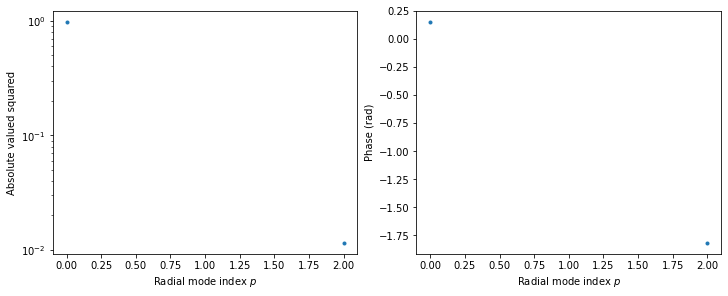

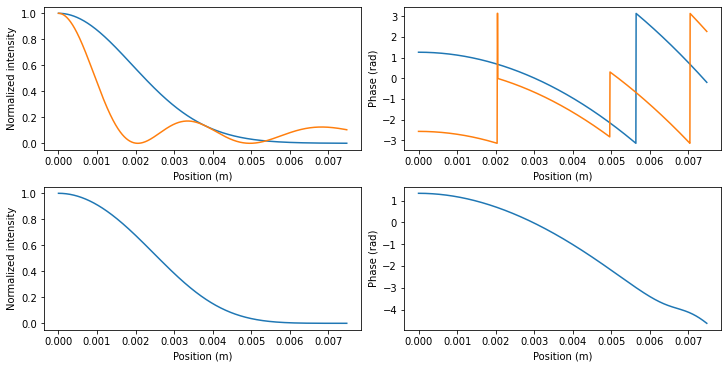

In [10]:
# Highlight Laguerre-Gauss modes with largest contributions to decomposition

# Filter coefficients
mask_coeffs = np.abs(coeffs)**2 > 1e-2

mask = (x >= 0) & (x <= 1.1*sample_size)
r = x[mask].to('m').value

# coeffs[2] = coeffs[2]*6

print(f'{1-np.sum(np.abs(coeffs)**2):.2e}')
print(f'{1-np.sum(np.abs(coeffs[mask_coeffs])**2):.2e}')

# Plot mode decomposition
fig, axs = plt.subplots(1, 2, num='Mode decomposition', figsize=(10, 4), constrained_layout=True)
linestyle = {'marker': 'o', 'linestyle': '', 'markersize': 3}    
axs[0].plot(ps[mask_coeffs], np.abs(coeffs[mask_coeffs])**2, **linestyle)
axs[1].plot(ps[mask_coeffs], np.angle(coeffs[mask_coeffs]), **linestyle)
axs[0].set_yscale('log')
for ax in axs:
    ax.set_xlabel(r'Radial mode index $p$')
axs[0].set_ylabel(r'Absolute valued squared')    
axs[1].set_ylabel(r'Phase (rad)')

# Plot mode reconstruction
# Position relative to beam waist at which reconstruction is shown
z_ = 2.*beam.zr
q_ = beam.q+z_
# Reconstructed mode from mode decomposition
reconst = np.sum(
    [coeff*beam.laguerre_gauss(p, 0, r, 0, q=q_)
     for p, coeff in zip(ps[mask_coeffs], coeffs[mask_coeffs])],
    axis=0)
print(4*beam.get_gouy_phase(q=q_))

fig, axs = plt.subplots(2, 2, num='Mode reconstruction', figsize=(10, 5), constrained_layout=True)
# Mode
for p in ps[mask_coeffs]:
    mode = coeffs[p]*beam.laguerre_gauss(p, 0, r, 0, q=q_)
    axs[0, 0].plot(
        r, np.abs(mode)**2/np.max(np.abs(mode)**2),
        ) 
    axs[0, 1].plot(
        r, np.angle(mode),
        )

axs[1, 0].plot(
    r, np.abs(reconst)**2/(np.abs(reconst)**2).max(),
    )
axs[1, 1].plot(
    r, np.unwrap(np.angle(reconst)),
    )
for ax in axs.flatten():
    ax.set_xlabel('Position (m)')
axs[0, 0].set_ylabel('Normalized intensity')
axs[0, 1].set_ylabel('Phase (rad)')
axs[1, 0].set_ylabel('Normalized intensity')
axs[1, 1].set_ylabel('Phase (rad)')

In [11]:
# Prepare M2 measurement by adding lens
wf_m2 = wf_initial.copy()
Y, X = wf_m2.coordinates()
# Focal length of M2 lens
f_m2 = 1000.*u.mm
# Gaussian beam after M2 lens
beam_m2 = copy.copy(beam)
abcd = abcd_thin_lens(f_m2.to('m').value)
beam_m2.apply_abcd(abcd)
# Position of beam waist after M2 lens
z_m2 = -beam_m2.z*u.m
# Beam waist after M2 lens
w0_m2 = beam_m2.w0*u.m
# Rayleigh length after M2 lens
zr_m2 = beam_m2.zr*u.m
# Calculate decomposition coefficients of beam after M2 lens,
# which have the same magnitude as the coefficients before the M2 lens - the mode content remains
# unchanged - but differ by a phase factor.
# However, this phase factor only stems from the change of the complex beam parameter that defines
# the modes used in the mode decomposition.
# The phase factor ensures that the phase between the modes at the position of the lens remains
# unchanged by the lens, that is, the only change from the lens is the complex beam parameter.
# To achieve this, the Gouy phase that the modes have picked up from the change in the complex beam
# parameter needs to subtracted again.
# The Gouy phase corresponds to
# `(2p + 1) arctan(z/zr)`,
# with the radial mode index `p`, the position `z` relative to the new position of the beam, 
# and new Rayleigh range `zr`.
# This is the phase that is subtracted here.
# Note that here the beam waist before the lens is exactly at the lens, that is, the Gouy phase
# is zero for all radial modes. Otherwise, this would also need to be accounted for to leave
# the relative phase at the position of the lens unchanged.
coeffs_m2 = [coeff*np.exp(-1j*(2*p+1)*beam_m2.psi) for p, coeff in zip(ps, coeffs)]
# Apply M2 lens
# Do *not* use `poppy.QuadraticLens`, as this leads to some internal magic appropriate
# for propagating from object to Fourier plane, image, ..., but not here.
wf_m2 = add_lens_phase(wf_m2, f_m2)
wavefronts[0] = wf_m2.wavefront.copy()
wavefront_cuts[0] = wf_m2.wavefront[ind_c, :]
wf_m2_sample = wf_m2.copy()
# zs_m2 = np.hstack(([0], np.linspace(f_m2-10*zr_m2, f_m2+10*zr_m2, num_iter)))
zrs = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 5, 10])
# zrs = np.array([0])
zrs = np.unique(np.hstack((-np.flipud(zrs), zrs)))
zs_m2 = np.hstack(([0], zrs*zr_m2+z_m2))

In [12]:
# Calculate M2 measurement by physical optics propagation (POP)
for i in range(1, len(zs_m2)):

    # Using internal poppy function that just propagates using FFT.
    # Do *not* use `wf_m2.propagate_fresnel`, as this will result in wrong results as poppy applies
    # some magic, assuming you want to propagate directly to the Fourier plane.
    # Note that the sign of the propagation distance is reversed in this case.
    wf_m2_sample._propagate_ptp(-(zs_m2[i]-zs_m2[i-1]))

    wavefront_cuts[i] = wf_m2_sample.wavefront[ind_c, :]
    wavefronts[i] = wf_m2_sample.wavefront.copy()

    print(f'Position {i:d}: {zs_m2[i].to("m"):.2e}')

Position 1: 5.47e-01 m
Position 2: 7.73e-01 m
Position 3: 8.40e-01 m
Position 4: 8.63e-01 m
Position 5: 8.85e-01 m
Position 6: 9.08e-01 m
Position 7: 9.30e-01 m
Position 8: 9.53e-01 m
Position 9: 9.75e-01 m
Position 10: 9.98e-01 m
Position 11: 1.02e+00 m
Position 12: 1.04e+00 m
Position 13: 1.07e+00 m
Position 14: 1.09e+00 m
Position 15: 1.11e+00 m
Position 16: 1.13e+00 m
Position 17: 1.16e+00 m
Position 18: 1.22e+00 m
Position 19: 1.45e+00 m


Text(0, 0.5, 'Normalized intensity')

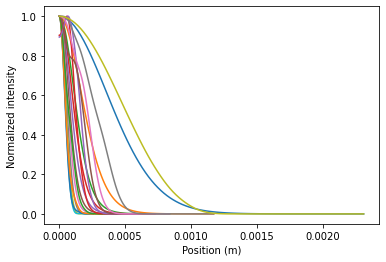

In [13]:
# Calculate M2 measurement by explicit integration of the Fresnel approximation to Kirchhoff's
# diffraction formula.
# This is here only done for rotationally symmetric fields, implemented by taking a cut along
# the x-axis.

# Number of radial sampling points at M2 measurement position
num_r_points_m2_sample = 100

r_m2_explicit = np.zeros((len(zs_m2), num_r_points_m2_sample))
wavefront_cuts_m2_explicit = np.zeros((len(zs_m2), num_r_points_m2_sample), dtype=np.complex128)

# Integration boundaries of field directly after lens
mask = (x >= 0) & (x <= 1*sample_size)
r = x[mask].to('m').value

ax = plt.gca()
for i in range(1, len(zs_m2)):
# for i in range(1, 2):

    z = zs_m2[i].to('m').value

    beam_m2_sample = copy.copy(beam_m2)
    beam_m2_sample.q += z
    w_sample = beam_m2_sample.w
    r_sample = np.linspace(0, 3*w_sample, num_r_points_m2_sample)
    diff_er = calc_fresnel_disc_e(
        r, wf_m2.wavefront[ind_c, mask],
        r_sample, z, wavelength.to('m').value)

    ax.plot(
        r_sample, np.abs(diff_er)**2/(np.abs(diff_er)**2).max(),
        )
    r_m2_explicit[i] = r_sample
    wavefront_cuts_m2_explicit[i] = diff_er

ax.set_xlabel('Position (m)')
ax.set_ylabel('Normalized intensity')

5.11e-06
5.11e-06


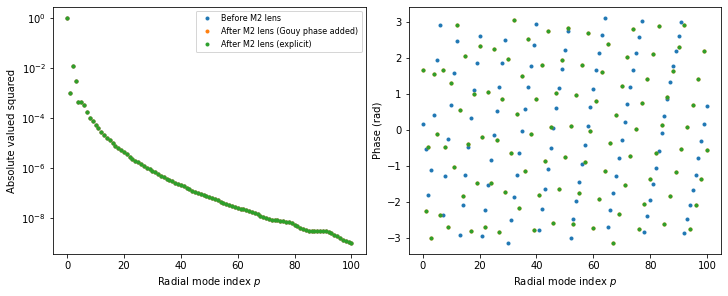

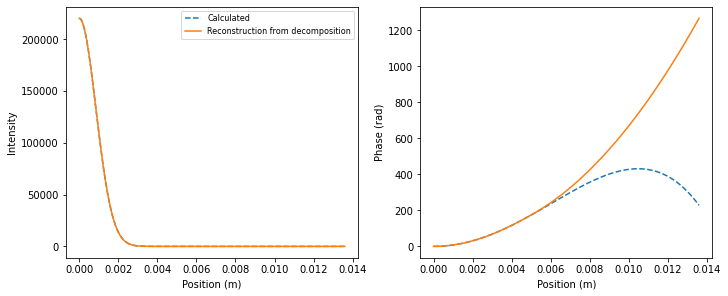

In [45]:
# Find decomposition of calculated beam after M2 lens into Laguerre-Gauss modes
mask = (x >= 0) & (x <= 2*sample_size)
r = x[mask].to('m').value

# Calculated beam
calc = wavefronts[0][ind_c, mask]
calc_norm_const = np.sqrt(scipy.integrate.trapezoid(2*np.pi*r*calc*np.conjugate(calc), r))
calc /= calc_norm_const

# Calculate decomposition coefficients by explicit integration of overlap integrals of beam after
# M2 lens
coeffs_m2_explicit = np.zeros(p_max+1, dtype=np.complex128)
for p in range(p_max+1):
    mode = beam_m2.laguerre_gauss(p, 0, r, 0)
    coeffs_m2_explicit[p] = scipy.integrate.trapezoid(2*np.pi*r*calc*np.conjugate(mode), r)

print(f'{1-np.sum(np.abs(coeffs_m2_explicit)**2):.2e}')

# Compare to decomposition coefficients of beam after M2 lens by adding additional Gouy phase of
# of Laguerre-Gauss modes from M2 lens to coefficents of beam before M2 lens
print(f'{1-np.sum(np.abs(coeffs_m2)**2):.2e}')

# Reconstructed mode from mode decomposition
reconst = np.sum([
    coeff*beam_m2.laguerre_gauss(p, 0, r, 0)
    for p, coeff in zip(ps, coeffs_m2)], axis=0)

# Plot mode decomposition
fig, axs = plt.subplots(
    1, 2,
    num='Mode decomposition',
    figsize=(10, 4),
    constrained_layout=True,
    )
linestyle = {'marker': 'o', 'linestyle': '', 'markersize': 3}
axs[0].plot(
    ps, np.abs(coeffs)**2,
    **linestyle, label='Before M2 lens')
axs[1].plot(ps, np.angle(coeffs), **linestyle)    
axs[0].plot(
    ps, np.abs(coeffs_m2)**2,
    **linestyle, label='After M2 lens (Gouy phase added)')
axs[1].plot(ps, np.angle(coeffs_m2), **linestyle)
axs[0].plot(
    ps, np.abs(coeffs_m2_explicit)**2,
    **linestyle, label='After M2 lens (explicit)')
axs[1].plot(ps, np.angle(coeffs_m2_explicit), **linestyle)
axs[0].set_yscale('log')
for ax in axs:
    ax.set_xlabel(r'Radial mode index $p$')
axs[0].set_ylabel(r'Absolute valued squared')    
axs[1].set_ylabel(r'Phase (rad)')
axs[0].legend(loc='best', fontsize=8)

# Plot mode reconstruction
# mask = (x >= 0) & (x <= 0.03*sample_size)
r = x[mask].to('m').value

fig, axs = plt.subplots(
    1, 2,
    num='Reconstructed mode',
    figsize=(10, 4),
    constrained_layout=True,
    )

reconst = np.sum([
    coeff*beam_m2.laguerre_gauss(p, 0, r, 0, q=beam_m2.q+0.)
    for p, coeff in zip(ps, coeffs_m2)], axis=0)

# calc_norm = np.max(np.abs(calc)**2)
# reconst_norm = np.max(np.abs(reconst)**2)
calc_norm = 1
reconst_norm = 1
axs[0].plot(
    r, np.abs(calc)**2/calc_norm, linestyle='--',
    label='Calculated',
    )
axs[0].plot(
    r, np.abs(reconst)**2/reconst_norm,
    label='Reconstruction from decomposition',    
    )
axs[1].plot(
    r, np.unwrap(np.angle(calc)), linestyle='--',
    )
axs[1].plot(
    r, np.unwrap(np.angle(reconst)),
    )
for ax in axs:
    ax.set_xlabel('Position (m)')
axs[0].set_ylabel('Intensity')
axs[1].set_ylabel('Phase (rad)')
axs[0].legend(loc='best', fontsize=8)

Text(0.01, 0.5, 'Intensity (arb. u.)')

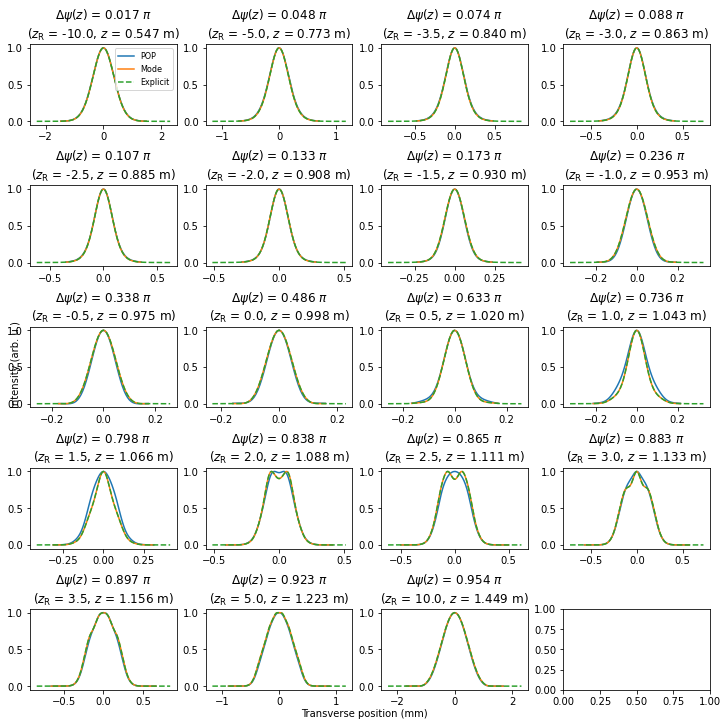

In [36]:
# Plot M2 measurement, that is, intensity cuts vs position around focus after M2 lens.
# Both the results from the diffraction calculation and the propagation of the mode
# decomposition are shown.

Nh = 4
Nv = int(np.ceil(len(zs_m2)/Nh))
fig, axs = plt.subplots(
    Nv, Nh,
    num='M2 plot',
    figsize=(10, 10),
    constrained_layout=True,
    )
axs_ = axs.flatten()

_, X = wf.coordinates()
# for i in np.arange(10, 12):
for j, i in enumerate(np.arange(1, len(zs_m2))):
    # POP
    # Intensity
    y = np.abs(wavefront_cuts[i])**2
    # Fit 1D Gaussian
    pstart = [np.sqrt(np.sum(x**2*y)/np.sum(y)).to('m').value]
    popt, pcov = scipy.optimize.curve_fit(
        gaussian_profile_int_1d, x.to('m').value, y/y.max(), pstart)
    w_fit = popt[0]*u.m
    # print(w_fit)
    mask = (x >= -2*w_fit) & (x <= 2*w_fit)    
    # Plot POP result
    axs_[j].plot(
        x[mask], y[mask]/y[mask].max(),
        label='POP')
    # Reconstruction        
    r = x[mask].to('m').value
    r_mm = x[mask].to('mm').value    
    reconst = np.sum([
        coeff*beam_m2.laguerre_gauss(p, 0, r, 0, q=beam_m2.q+(zs_m2[i]).to('m').value)
        for p, coeff in zip(ps, coeffs_m2)], axis=0)        
    y_reconst = np.abs(reconst)**2
    # Plot mode decomposition result
    axs_[j].plot(
        r_mm, y_reconst/y_reconst.max(),
        label='Mode',
        # linestyle='--',
        )
    # Plot explicit integration results
    r_explicit_mm = 1e3*np.hstack((-np.flipud(r_m2_explicit[i]), r_m2_explicit[i]))    
    y_explicit = np.abs(wavefront_cuts_m2_explicit[i])**2
    y_explicit = np.hstack((np.flipud(y_explicit), y_explicit))
    axs_[j].plot(
        r_explicit_mm,
        y_explicit/y_explicit.max(),
        label='Explicit',
        linestyle='--',
        )
    # Plot 1D Gaussian fit
    # axs_[j].plot(
    #     x[mask], gaussian_profile_int_1d(x[mask].to('m').value, *popt))        
    # Gouy phase picked up by fundamental mode by propagation from plane where aberrations
    # where imprinted, which here is the also the plane of the M2 lens
    delta_gouy = (np.arctan(((zs_m2[i])-z_m2)/zr_m2).value-beam_m2.psi)/np.pi
    axs_[j].set_title(
        rf'$\Delta\psi(z)$ = {delta_gouy:.3f} $\pi$'
        +'\n'+rf'($z_\mathrm{{R}}$ = {((zs_m2[i]-z_m2)/zr_m2).to(""):.1f}'
        +rf', $z$ = {zs_m2[i].to("m"):.3f})')        

# for ax in axs_:
#     ax.set_ylim([0.8, 1.0])
axs_[0].legend(loc='best', fontsize=8)
axs_[j].set_xlabel(' ')
fig.text(0.5, 0.01, 'Transverse position (mm)', ha='center')
fig.text(0.01, 0.5, 'Intensity (arb. u.)', va='center', rotation='vertical')

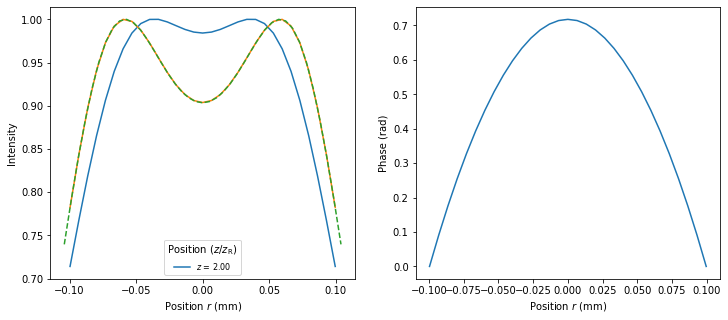

In [16]:
# Plot selected results from M2 measurement
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = axs[0]
_, X = wf.coordinates()
# for i in np.arange(1, len(zs_m2)):
for i in np.arange(14, 15):
    # POP
    # Intensity
    y = np.abs(wavefront_cuts[i])**2
    # Fit 1D Gaussian
    pstart = [np.sqrt(np.sum(x**2*y)/np.sum(y)).to('m').value]
    popt, pcov = scipy.optimize.curve_fit(
        gaussian_profile_int_1d, x.to('m').value, y/y.max(), pstart)
    w_fit = popt[0]*u.m
    # print(w_fit)
    max_r = 0.5*w_fit
    mask = (x >= -max_r) & (x <= max_r)
    # Plot POP result
    axs[0].plot(
        x[mask], y[mask]/y[mask].max(),
        label=rf'$z$ = {((zs_m2[i]-z_m2)/zr_m2).to(""):.2f}')
    # Reconstruction        
    r = x[mask].to('m').value
    r_mm = x[mask].to('mm').value    
    reconst = np.sum([
        coeff*beam_m2.laguerre_gauss(p, 0, r, 0, q=beam_m2.q+(zs_m2[i]).to('m').value)
        for p, coeff in zip(ps, coeffs_m2)], axis=0)        
    y_reconst = np.abs(reconst)**2
    # Plot mode decomposition result
    axs[0].plot(
        r_mm, y_reconst/y_reconst.max(),
        # linestyle='--',
        )
    # Plot explicit integration results
    r_explicit = np.hstack((-np.flipud(r_m2_explicit[i]), r_m2_explicit[i]))    
    mask_explicit = (r_explicit >= -max_r.to('m').value) & (r_explicit <= max_r.to('m').value)
    r_explicit_mm = 1e3*r_explicit
    y_explicit = np.abs(wavefront_cuts_m2_explicit[i])**2
    y_explicit = np.hstack((np.flipud(y_explicit), y_explicit))
    axs[0].plot(
        r_explicit_mm[mask_explicit],
        y_explicit[mask_explicit]/y_explicit[mask_explicit].max(),
        linestyle='--',
    )
    # Plot 1D Gaussian fit
    # axs[0].plot(
    #     x[mask], gaussian_profile_int_1d(x[mask].to('m').value, *popt))        
    # Phase of electric field (relative to value at origin)
    y = np.unwrap(np.angle(wavefront_cuts[i, mask]))
    axs[1].plot(
        x[mask], y-y[0])        
    
for ax in axs:
    ax.set_xlabel(r'Position $r$ (mm)')
axs[0].set_ylabel('Intensity')
# axs[0].set_ylim([0.8, 1])
# axs[0].set_ylabel('Normalized amplitude')
axs[1].set_ylabel('Phase (rad)')
axs[0].legend(title=r'Position ($z/z_\mathrm{R}$)', loc='best', fontsize=8)